In [ ]:
#Affected Tracts

In [1]:
import zipfile 
import pysal as ps
%matplotlib inline
import numpy as np
import ast
import json
import urllib
import urllib2
from cStringIO import StringIO
import pandas as pd
import requests
import os
import geopandas as gpd
import matplotlib.pylab as pl
from fiona.crs import from_epsg
import matplotlib.pylab as pl
from matplotlib import colors
import shapely
import seaborn as sns
import gzip
import mapreduce as mr
import csv
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from time import sleep

In [52]:
fname = 'Data/CensusTracks.geojson'
tracts = gpd.GeoDataFrame.from_file(fname)

In [53]:
affectedTracts = tracts[tracts.Within15min == True]

In [4]:
# We can further isolate specific areas (like williamsburg)
# using ntaname (Legacy, we want walking distance)

#affectedTracts = tracts[(tracts.Within15min == True) &
#                       ((tracts.ntaname == 'Williamsburg') |
#                        (tracts.ntaname == 'East Williamsburg'))]

In [5]:
SQL_SOURCE = 'https://fernando-melchor.carto.com/api/v2/sql'

In [6]:
# functoin to query CartoDB
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [7]:
# Retreive the NYC map with Zip Codes shapes and store in geodataframe

NYCshapeQuery = '''
SELECT *
FROM nyc_zip_code
'''
NYCshapeStream = queryCartoDB(NYCshapeQuery, format = 'GeoJSON')
NYCshapeData   = json.loads(NYCshapeStream.read())
NYCshape     = gpd.GeoDataFrame.from_features(NYCshapeData['features'])

NYCshape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
#NYCshape.to_crs(epsg = 2263, inplace = True) # from ft2 to mi2 

In [8]:
# Load the subway lines geodataframe
subline = gpd.GeoDataFrame.from_file('Subway Lines.geojson')
subline.crs = from_epsg(4326) #= from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
#NYCshape.to_crs(epsg = 2263, inplace = True) # from ft2 to mi2 

In [9]:
# Retreive the Subway Stations geodataframe
subStations = gpd.GeoDataFrame.from_file('Subway Stations.geojson')
subStations.crs = from_epsg(4326)

In [10]:
# Filter L train only (line and stations)
lsubline = subline[(subline.rt_symbol=='L')]
lsubStations = subStations[(subStations.line=='L')]

In [11]:
# Select subset of stations for Brooklyn
# With significant number of jobs in manhattan
# After revieing the LODES data based map

# Bedford Avenue / North 7 Street
# Lorimer Street / Metropolitan Avenue
# Graham Avenue / Metropolitan Avenue
# Grand Street / Bushwick Avenue
# Montrose Avenue / Bushwick Avenue
# Morgan Avenue / Harrisn Place
# Jefferson Street / Wyckoff Avenue
# DeKalb Avenue / Wyckoff Avenue
# Myrtle-Wyckoff Avenues
# Halsey Street / Wyckoff Avenue
# Wilson Avenue / Moffat Street
# Bushwick Avenue- Aberdeen Street
# Broadway Junction (Fulton Street)

commuteAffectedStations = ["151", "72", "150", "149", "152", "306", "305",
                          "235", "212", "211", "74", "282", "283"]

In [12]:
# Use the array with the ids of the stations
# to filter our L statios dataframe

lAffectedStations = lsubStations[lsubStations.objectid.isin(commuteAffectedStations)]

In [13]:
def getXY(pt):
    return pt.x, pt.y

key = os.getenv("MAPZENKEY")

In [16]:
url = 'http://matrix.mapzen.com/isochrone?json={"locations":[{"lat":'+\
str(getXY(lAffectedStations.geometry.iloc[0])[1])+\
',"lon":'+str(getXY(lAffectedStations.geometry.iloc[0])[0])+\
'}],"costing":"pedestrian","contours":[{"time":15,"color":"ff0000"}]}\
&id=Walk_From_L&api_key='+(os.getenv("MAPZENKEY"))

In [17]:
url

'http://matrix.mapzen.com/isochrone?json={"locations":[{"lat":40.7140720006,"lon":-73.950248}],"costing":"pedestrian","contours":[{"time":15,"color":"ff0000"}]}&id=Walk_From_L&api_key=mapzen-c3SPaAi'

In [36]:
# Use MAPZEN to get the 15 minute walking distance area
# From the Subway Stations

url = 'http://matrix.mapzen.com/isochrone?json={"locations":[{"lat":'+\
str(getXY(lAffectedStations.geometry.iloc[0])[1])+\
',"lon":'+str(getXY(lAffectedStations.geometry.iloc[0])[0])+\
'}],"costing":"pedestrian","contours":[{"time":15,"color":"ff0000"}]}\
&id=Walk_From_L&api_key='+(os.getenv("MAPZENKEY"))

response = urllib2.urlopen(url)
data = response.read().decode('utf-8')
dataDict = json.loads(data)
mainPolygon = Polygon(dataDict['features'][0]['geometry']['coordinates'])

In [46]:
for station in lAffectedStations.geometry[1:]:
    url = 'http://matrix.mapzen.com/isochrone?json={"locations":[{"lat":'+\
    str(getXY(station)[1])+\
    ',"lon":'+str(getXY(station)[0])+\
    '}],"costing":"pedestrian","contours":[{"time":15,"color":"ff0000"}]}'+\
    '&id=Walk_From_L&api_key='+(os.getenv("MAPZENKEY"))
    #print (url)
    response = urllib2.urlopen(url)
    data = response.read().decode('utf-8')
    dataDict = json.loads(data)
    secPolygon = Polygon(dataDict['features'][0]['geometry']['coordinates'])
    mainPolygon = cascaded_union([mainPolygon,secPolygon])
    sleep(3)

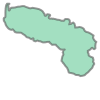

In [47]:
mainPolygon

In [55]:
WalkingDist = gpd.GeoDataFrame.from_dict([{'geometry':0,'Walkingtime':0},
                                          {'geometry':0,'Walkingtime':0}])

In [56]:
WalkingDist.Walkingtime[0]=15
WalkingDist.geometry[0]=mainPolygon
WalkingDist

,Walkingtime,geometry
0,15,"POLYGON ((-73.89546199999999 40.687023, -73.89..."
1,0,0


In [57]:
def pointinsidepoligon15(point):
    return point.within(WalkingDist.geometry[0])

In [59]:
affectedTracts['bigManhattanCommute'] = False

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [62]:
affectedTracts['BlockCentroid'] = affectedTracts['geometry'].centroid

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [63]:
affectedTracts['bigManhattanCommute'] =\
affectedTracts.BlockCentroid.map(pointinsidepoligon15)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


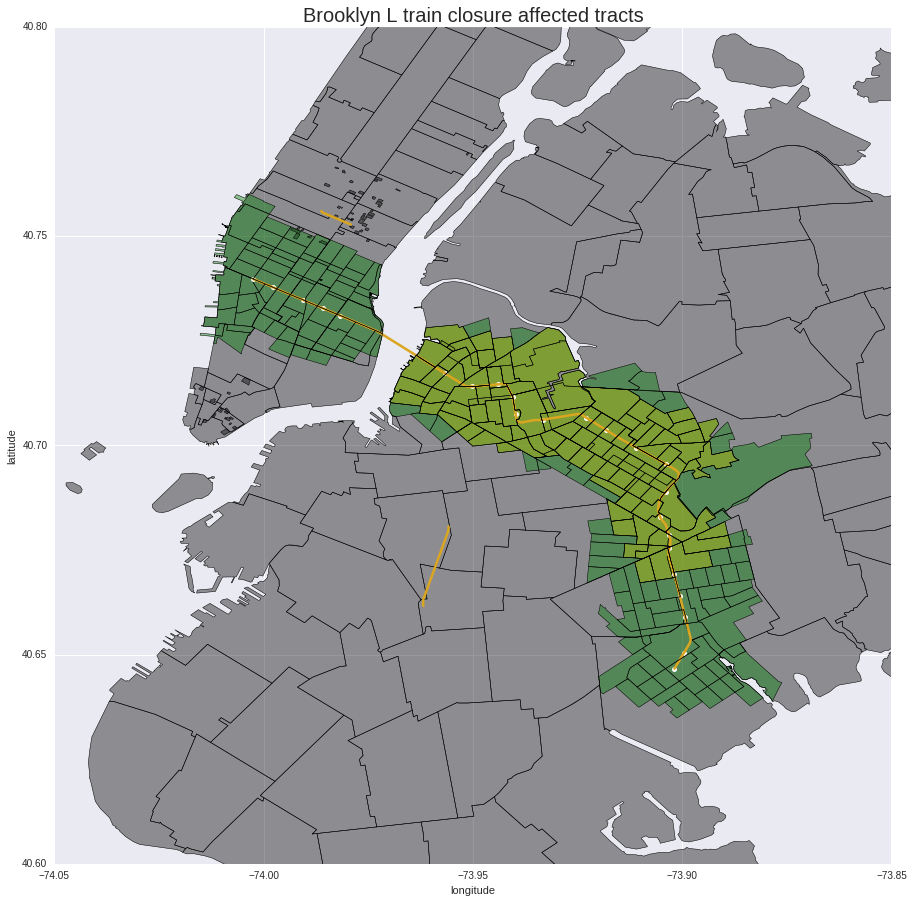

In [67]:
# Plot with the affected Tracts (Filtered by )

f, ax = pl.subplots(figsize=(15,15))

NYCshape.plot(linewidth = 0.5, color = 'k', ax = ax,alpha=.4)
lsubStations.plot(marker='o', markersize=5, linewidth = 4, color = 'w', ax = ax)
lsubline.plot(linewidth = 2.5, color = 'goldenrod' , ax = ax)
affectedTracts.plot(linewidth = 0.5, color = 'g', ax = ax, alpha=.4)
affectedTracts[affectedTracts.bigManhattanCommute == True].plot\
(linewidth = 0.5, color = 'y', ax = ax, alpha=.4)
pl.xlabel('longitude')
pl.ylabel('latitude')
pl.ylim(40.6, 40.8)
pl.xlim(-74.05, -73.85)
#ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
pl.title("Brooklyn L train closure affected tracts", size=20)